In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import copy as cp
import glob
%matplotlib inline

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    """ class Line:  """
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        
        # x values of the last n fits of the line
        self.recent_xfitted = []
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        
        #x values for detected line pixels
        self.allx = None
        
        #y values for detected line pixels
        self.ally = None

## Step 1: Camera Calibration

In [3]:
# chessboard size is different in this one
nx, ny = 9, 6

objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
#images = [ 'camera_cal/calibration2.jpg' ]

# Step through the list and search for chessboard corners
foundCount = 0
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray_img, (nx, ny), None)

    if ret == True:
        foundCount += 1
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

print ('Found chessboard in %d out of %d images' % (foundCount, len(images)))

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
cameraCaleb = {
    'ret' : ret
    , 'mtx' : mtx
    , 'dist': dist
    , 'rvecs' : rvecs
    , 'tvecs' : tvecs
}

print ("Saving results to `cameraCaleb.pickle`")
with open('cameraCaleb.pickle', 'wb') as f:
    pickle.dump(cameraCaleb, f)


Found chessboard in 17 out of 20 images
Saving results to `cameraCaleb.pickle`


### Load Pickled Camera Calibration Info

In [4]:
with open('cameraCaleb.pickle', 'rb') as f:
    cameraCaleb = pickle.load(f)

## Step 2: Distortion Correction

In [5]:
def undistort_img(img):
    return cv2.undistort(img, cameraCaleb['mtx'], cameraCaleb['dist'], None, cameraCaleb['mtx'])

In [6]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def transform(img):
    # Get the dimensions
    width, height = img.shape[1], img.shape[0]
    img_size = (width, height)
    
    # define the trapezoid
    src = np.float32([[605, 445], [685, 445],
                      [1063, 676], [260, 676]])
    dst = np.float32([[width * 0.35, 0], [width * 0.65, 0], 
                      [width * 0.65, height], [ width * 0.35, height]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
        
    # Warp the image using OpenCV warpPerspective()
    return cv2.warpPerspective(img, M, (int(width), int(height)), flags=cv2.INTER_LINEAR), M, Minv


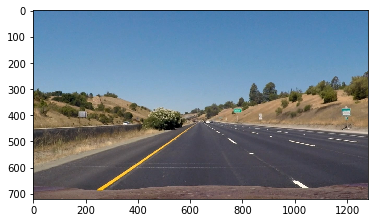

In [8]:
# Let's make sure we know what we're doing here.
img1 = mpimg.imread('test_images/straight_lines1.jpg')
fimg = transform(undistort_img(img1))
plt.imshow(img1)


## Step 3: Color/gradient threshold

In [9]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return s_binary
    

## Step 4: Perspective transform

## Step 5: Detect lane lines

## Step 6: Determine the lane curvature

In [16]:
def fitPolyLanes(binary_warped):
    """ fitPolyLanes - fit a polynomial curve """
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    print(binary_warped.shape)
    
    #histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    histogram = np.sum(binary_warped, axis=0)
    
    plt.show(histogram)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    minpoint = np.int(histogram.shape[0] * 0.25)
    maxpoint = np.int(histogram.shape[0] * 0.75)
    leftx_base = np.argmax(histogram[minpoint:midpoint]) + minpoint
    rightx_base = np.argmax(histogram[midpoint:maxpoint]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255, 0), 2) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255, 0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, histogram, out_img

In [17]:
def visualisePolyFit (img, leftLaneFit, rightLaneFit, leftLaneInds, rightLaneInds):
    """ visualisePolyFit """
    
    # Generate x and y values for plotting
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Calculate the actual fitted plots
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = leftLaneFit[0] * ploty**2 + leftLaneFit[1] * ploty + leftLaneFit[2]
    right_fitx = rightLaneFit[0] * ploty**2 + rightLaneFit[1] * ploty + rightLaneFit[2]
    
    # 
    out_img = np.dstack((img, img, img))*255
    out_img[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
    out_img[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [0, 0, 255]
    plt.imshow(out_img)
    
    # Plot the actual lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [18]:
def overlayGreenZone(undist, warped, leftLaneFit, rightLaneFit):
    """ Overlay a green zone on the original image """
    
    # Get the x,y of the fitted lines
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    left_fitx = leftLaneFit[0]*ploty**2 + leftLaneFit[1]*ploty + leftLaneFit[2]
    right_fitx = rightLaneFit[0]*ploty**2 + rightLaneFit[1]*ploty + rightLaneFit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    
    # Combine the result with the original image
    return cv2.addWeighted(undist, 1, newwarp, 0.3, 0)


In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
def process_image (img):
    """ """
    undist = undistort_img(img)

    # color and gradient
    gray_bin = pipeline(undist)

    # transform
    warped, M, Minv = transform(gray_bin)

    # fit lanes (left & right)
    leftLane, rightLane, leftLaneInds, rightLaneInds, histogram, out_img = fitPolyLanes(warped)
    #cv2.imwrite('hello.jpg',out_img)

    # draw lane fits
    #drawn = visualisePolyFit(warped, leftLane, rightLane, leftLaneInds, rightLaneInds)

    # draw the green zone for the car
    return overlayGreenZone (undist, warped, leftLane, rightLane)
    

## Single image pipeline

In [22]:
# Read in the original test image

#img = cv2.imread ('test_images/test5.jpg')
img = cv2.imread('test_images/test2.jpg')
# undistort it
undist = undistort_img(img)

# color and gradient
gray_bin = pipeline(undist)

# transform
warped, M, Minv = transform(gray_bin)

# fit lanes (left & right)
leftLane, rightLane, leftLaneInds, rightLaneInds, histogram, out_img = fitPolyLanes(warped)

# draw lane fits
drawn = visualisePolyFit(warped, leftLane, rightLane, leftLaneInds, rightLaneInds)

# draw the green zone for the car
img_zone = overlayGreenZone (undist, warped, leftLane, rightLane)

plt.imshow(histogram)


(720, 1280)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Project video

In [ ]:
white_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("input_videos/project_video.mp4").subclip(0,10)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Harder video

In [30]:
white_output = 'output_videos/challenge_video.mp4'
clip1 = VideoFileClip("input_videos/challenge_video.mp4").subclip(0,10)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

(720, 1280)


TypeError: expected non-empty vector for x

In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Harder challenger video

In [34]:
white_output = 'output_videos/harder_challenge_video.mp4'
clip1 = VideoFileClip("input_videos/harder_challenge_video.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

(720, 1280)
[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4



  0%|          | 0/126 [00:00<?, ?it/s]

(720, 1280)



  1%|          | 1/126 [00:00<00:22,  5.67it/s]

(720, 1280)



  2%|▏         | 3/126 [00:00<00:19,  6.20it/s]

(720, 1280)


(720, 1280)



  3%|▎         | 4/126 [00:00<00:19,  6.25it/s]

(720, 1280)



  4%|▍         | 5/126 [00:00<00:19,  6.21it/s]

(720, 1280)



  5%|▍         | 6/126 [00:00<00:19,  6.11it/s]

(720, 1280)



  6%|▌         | 7/126 [00:01<00:19,  6.06it/s]

(720, 1280)



  6%|▋         | 8/126 [00:01<00:18,  6.26it/s]

(720, 1280)



  7%|▋         | 9/126 [00:01<00:18,  6.19it/s]

(720, 1280)



  9%|▊         | 11/126 [00:01<00:18,  6.32it/s]

(720, 1280)



 10%|▉         | 12/126 [00:01<00:17,  6.42it/s]

(720, 1280)


(720, 1280)



 10%|█         | 13/126 [00:02<00:17,  6.29it/s]

(720, 1280)



 11%|█         | 14/126 [00:02<00:18,  6.06it/s]

(720, 1280)



 13%|█▎        | 16/126 [00:02<00:17,  6.36it/s]

(720, 1280)



 13%|█▎        | 17/126 [00:02<00:16,  6.52it/s]

(720, 1280)


(720, 1280)



 14%|█▍        | 18/126 [00:02<00:16,  6.45it/s]

(720, 1280)



 15%|█▌        | 19/126 [00:03<00:16,  6.46it/s]

(720, 1280)



 17%|█▋        | 21/126 [00:03<00:16,  6.54it/s]

(720, 1280)



 17%|█▋        | 22/126 [00:03<00:15,  6.64it/s]

(720, 1280)



 18%|█▊        | 23/126 [00:03<00:15,  6.76it/s]

(720, 1280)



 19%|█▉        | 24/126 [00:03<00:15,  6.76it/s]

(720, 1280)



 20%|█▉        | 25/126 [00:03<00:14,  6.86it/s]

(720, 1280)



 21%|██        | 26/126 [00:04<00:14,  6.74it/s]

(720, 1280)


(720, 1280)



 21%|██▏       | 27/126 [00:04<00:16,  6.14it/s]

(720, 1280)



 22%|██▏       | 28/126 [00:04<00:15,  6.28it/s]

(720, 1280)



 24%|██▍       | 30/126 [00:04<00:14,  6.49it/s]

(720, 1280)



 25%|██▍       | 31/126 [00:04<00:14,  6.58it/s]

(720, 1280)


(720, 1280)



 25%|██▌       | 32/126 [00:04<00:14,  6.52it/s]

(720, 1280)



 26%|██▌       | 33/126 [00:05<00:14,  6.28it/s]

(720, 1280)



 27%|██▋       | 34/126 [00:05<00:14,  6.29it/s]

(720, 1280)



 28%|██▊       | 35/126 [00:05<00:15,  6.05it/s]

(720, 1280)



 29%|██▊       | 36/126 [00:05<00:14,  6.02it/s]

(720, 1280)



 30%|███       | 38/126 [00:05<00:13,  6.29it/s]

(720, 1280)



 31%|███       | 39/126 [00:06<00:13,  6.47it/s]

(720, 1280)



 32%|███▏      | 40/126 [00:06<00:12,  6.72it/s]

(720, 1280)



 33%|███▎      | 41/126 [00:06<00:12,  6.77it/s]

(720, 1280)



 33%|███▎      | 42/126 [00:06<00:12,  6.85it/s]

(720, 1280)



 34%|███▍      | 43/126 [00:06<00:12,  6.88it/s]

(720, 1280)



 35%|███▍      | 44/126 [00:06<00:11,  6.86it/s]

(720, 1280)



 36%|███▌      | 45/126 [00:06<00:11,  6.83it/s]

(720, 1280)



 37%|███▋      | 46/126 [00:07<00:11,  6.81it/s]

(720, 1280)



 37%|███▋      | 47/126 [00:07<00:11,  6.74it/s]

(720, 1280)



 38%|███▊      | 48/126 [00:07<00:11,  6.68it/s]

(720, 1280)


(720, 1280)



 39%|███▉      | 49/126 [00:07<00:11,  6.61it/s]

(720, 1280)



 40%|███▉      | 50/126 [00:07<00:11,  6.48it/s]

(720, 1280)



 40%|████      | 51/126 [00:07<00:11,  6.36it/s]

(720, 1280)



 41%|████▏     | 52/126 [00:08<00:11,  6.29it/s]

(720, 1280)



 42%|████▏     | 53/126 [00:08<00:12,  5.88it/s]

(720, 1280)



 43%|████▎     | 54/126 [00:08<00:12,  5.66it/s]

(720, 1280)



 44%|████▎     | 55/126 [00:08<00:12,  5.54it/s]

(720, 1280)



 44%|████▍     | 56/126 [00:08<00:12,  5.45it/s]

(720, 1280)



 45%|████▌     | 57/126 [00:09<00:12,  5.62it/s]

(720, 1280)



 46%|████▌     | 58/126 [00:09<00:11,  5.84it/s]

(720, 1280)



 47%|████▋     | 59/126 [00:09<00:11,  5.83it/s]

(720, 1280)



 48%|████▊     | 60/126 [00:09<00:11,  5.80it/s]

(720, 1280)



 48%|████▊     | 61/126 [00:09<00:11,  5.79it/s]

(720, 1280)



 49%|████▉     | 62/126 [00:09<00:10,  5.87it/s]

(720, 1280)



 50%|█████     | 63/126 [00:10<00:10,  6.03it/s]

(720, 1280)



 51%|█████     | 64/126 [00:10<00:10,  6.13it/s]

(720, 1280)



 52%|█████▏    | 65/126 [00:10<00:09,  6.21it/s]

(720, 1280)



 52%|█████▏    | 66/126 [00:10<00:09,  6.19it/s]

(720, 1280)



 54%|█████▍    | 68/126 [00:10<00:09,  6.43it/s]

(720, 1280)



 55%|█████▍    | 69/126 [00:10<00:08,  6.51it/s]

(720, 1280)



 56%|█████▌    | 70/126 [00:11<00:08,  6.57it/s]

(720, 1280)



 56%|█████▋    | 71/126 [00:11<00:08,  6.71it/s]

(720, 1280)



 57%|█████▋    | 72/126 [00:11<00:07,  6.79it/s]

(720, 1280)



 58%|█████▊    | 73/126 [00:11<00:07,  6.72it/s]

(720, 1280)


(720, 1280)



 59%|█████▊    | 74/126 [00:11<00:07,  6.58it/s]

(720, 1280)



 60%|█████▉    | 75/126 [00:11<00:07,  6.40it/s]

(720, 1280)



 60%|██████    | 76/126 [00:12<00:07,  6.31it/s]

(720, 1280)



 61%|██████    | 77/126 [00:12<00:07,  6.13it/s]

(720, 1280)



 63%|██████▎   | 79/126 [00:12<00:07,  6.29it/s]

(720, 1280)



 63%|██████▎   | 80/126 [00:12<00:07,  6.41it/s]

(720, 1280)


(720, 1280)



 64%|██████▍   | 81/126 [00:12<00:07,  6.32it/s]

(720, 1280)



 65%|██████▌   | 82/126 [00:12<00:07,  6.22it/s]

(720, 1280)



 67%|██████▋   | 84/126 [00:13<00:06,  6.29it/s]

(720, 1280)



 67%|██████▋   | 85/126 [00:13<00:06,  6.39it/s]

(720, 1280)



 68%|██████▊   | 86/126 [00:13<00:06,  6.45it/s]

(720, 1280)


(720, 1280)



 70%|██████▉   | 88/126 [00:13<00:05,  6.47it/s]

(720, 1280)



 71%|███████   | 89/126 [00:14<00:05,  6.56it/s]

(720, 1280)


(720, 1280)



 71%|███████▏  | 90/126 [00:14<00:05,  6.45it/s]

(720, 1280)



 72%|███████▏  | 91/126 [00:14<00:05,  6.00it/s]

(720, 1280)



 73%|███████▎  | 92/126 [00:14<00:05,  5.92it/s]

(720, 1280)



 75%|███████▍  | 94/126 [00:14<00:05,  6.18it/s]

(720, 1280)



 75%|███████▌  | 95/126 [00:15<00:04,  6.36it/s]

(720, 1280)



 76%|███████▌  | 96/126 [00:15<00:04,  6.58it/s]

(720, 1280)



 77%|███████▋  | 97/126 [00:15<00:04,  6.69it/s]

(720, 1280)



 78%|███████▊  | 98/126 [00:15<00:04,  6.78it/s]

(720, 1280)


(720, 1280)



 79%|███████▉  | 100/126 [00:15<00:03,  6.59it/s]

(720, 1280)


(720, 1280)



 80%|████████  | 101/126 [00:15<00:03,  6.52it/s]

(720, 1280)



 82%|████████▏ | 103/126 [00:16<00:03,  6.54it/s]

(720, 1280)



 83%|████████▎ | 104/126 [00:16<00:03,  6.53it/s]

(720, 1280)



 83%|████████▎ | 105/126 [00:16<00:03,  6.71it/s]

(720, 1280)



 84%|████████▍ | 106/126 [00:16<00:02,  6.73it/s]

(720, 1280)



 85%|████████▍ | 107/126 [00:16<00:02,  6.73it/s]

(720, 1280)


(720, 1280)



 87%|████████▋ | 109/126 [00:17<00:02,  6.63it/s]

(720, 1280)


(720, 1280)



 88%|████████▊ | 111/126 [00:17<00:02,  6.49it/s]

(720, 1280)



 89%|████████▉ | 112/126 [00:17<00:02,  6.55it/s]

(720, 1280)



 90%|████████▉ | 113/126 [00:17<00:01,  6.67it/s]

(720, 1280)


(720, 1280)



 90%|█████████ | 114/126 [00:17<00:01,  6.53it/s]

(720, 1280)



 91%|█████████▏| 115/126 [00:18<00:01,  6.44it/s]

(720, 1280)



 92%|█████████▏| 116/126 [00:18<00:01,  6.31it/s]

(720, 1280)



 93%|█████████▎| 117/126 [00:18<00:01,  6.28it/s]

(720, 1280)



 94%|█████████▍| 119/126 [00:18<00:01,  6.49it/s]

(720, 1280)



 95%|█████████▌| 120/126 [00:18<00:00,  6.71it/s]

(720, 1280)



 96%|█████████▌| 121/126 [00:18<00:00,  6.77it/s]

(720, 1280)



 97%|█████████▋| 122/126 [00:19<00:00,  6.81it/s]

(720, 1280)



 98%|█████████▊| 123/126 [00:19<00:00,  6.92it/s]

(720, 1280)



 98%|█████████▊| 124/126 [00:19<00:00,  6.87it/s]

(720, 1280)



 99%|█████████▉| 125/126 [00:19<00:00,  6.86it/s]

(720, 1280)


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

CPU times: user 18.5 s, sys: 3.44 s, total: 21.9 s
Wall time: 20.8 s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))